In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import json
import csv
import os
from bmtool.util.util import load_nodes_from_paths

from analysis import plot, utils, process # imoporting analysis module enables import from model folder
from build_input import get_populations, get_stim_cycle, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "ramp_a0_t1.0"
STIM_FILE = "thalamus_ramp_a0_t1.0"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

### Load data

In [2]:
stimulus_type, config = utils.stimulus_type_from_trial_name(TRIAL_NAME)
isstandard = stimulus_type == 'short' or stimulus_type == 'long'  # do not apply for baseline case

pop_color = plot.pop_color
pop_names = plot.pop_names

In [3]:
result_config_file = os.path.join('..', 'Analysis', TRIAL_PATH, config)
if not os.path.isfile(result_config_file):
    result_config_file = os.path.join(os.path.split(result_config_file)[0], utils.STIMULUS_CONFIG['else'])

config_hp = utils.ConfigHelper(result_config_file)
t_stop = config_hp.get_attr('run', 'tstop') / 1000

INPUT_PATH, _ = os.path.split(config_hp.get_attr('inputs', 'baseline_spikes', 'input_file'))

stim_file = 'standard_stimulus' if isstandard else STIM_FILE
with open(os.path.join(INPUT_PATH, stim_file + '.json')) as f:
    stim_setting = json.load(f)
stim_params = stim_setting[stimulus_type if isstandard else 'stim_params']

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']
t_cycle, n_cycle = get_stim_cycle(on_time, off_time, t_start, t_stop)

In [4]:
network_name = 'cortex'

node_df = load_nodes_from_paths(config_hp.get_attr('networks', 'nodes'))[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spike_file = os.path.join('..', 'Analysis', TRIAL_PATH, 'spikes.h5')
spikes_df = utils.load_spikes_to_df(spike_file, network_name)

### Get population spike rate

In [5]:
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
assy_ids = {i: ids for i, ids in enumerate(Assembly_ids)}

assy_idx = list(range(len(Assembly_ids))) if isstandard \
    else stim_setting['setting']['assembly_index']
n_assy = len(assy_idx)

rest_assy_idx = assy_ids.keys() - set(assy_idx)
if rest_assy_idx:
    assy_ids[-1] = sorted(n for i in rest_assy_idx for n in assy_ids[i])
    assy_idx = [-1] + assy_idx
assy_ids = {i: assy_ids[i] for i in assy_idx}

PN_pop_names = ['CP', 'CS']
pop_color_dark = {p: 'dark' + plot.pop_color_base[p] for p in PN_pop_names}
group_ids = {(p, i): sorted(set(pop_ids[p]) & set(assy_ids[i]))
             for p in PN_pop_names for i in assy_idx}

In [6]:
fs = 400.
time = np.linspace(0., 1000. * t_stop, int(t_stop * fs), endpoint=False)
grp_rspk = process.group_spike_rate_to_xarray(spikes_df, time, group_ids)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time, pop_ids, group_dims='population')
display(grp_rspk)
display(pop_rspk)

e:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
e:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


<xarray.Dataset>
Dimensions:            (time: 8400, population: 2, assembly: 2)
Coordinates:
  * time               (time) float64 1.25 3.75 6.25 ... 2.1e+04 2.1e+04
  * population         (population) object 'CP' 'CS'
  * assembly           (assembly) int64 -1 0
Data variables:
    spike_rate         (population, assembly, time) float64 0.0 0.0 ... 1.01 0.0
    population_number  (population, assembly) int32 3596 404 3604 396
Attributes:
    fs:       400.0

<xarray.Dataset>
Dimensions:            (time: 8400, population: 4)
Coordinates:
  * time               (time) float64 1.25 3.75 6.25 ... 2.1e+04 2.1e+04
  * population         (population) object 'CP' 'CS' 'FSI' 'LTS'
Data variables:
    spike_rate         (population, time) float64 0.0 0.0 1.6 ... 7.0 9.5 8.0
    population_number  (population) int32 4000 4000 1200 800
Attributes:
    fs:       400.0

### Analyze population spike rate

In [7]:
windows = 1000. * process.get_stim_windows(on_time, off_time, t_start, t_stop, only_on_time=False)
win_grp_idx = {i: list(range(i, windows.shape[0], n_assy))
               if i >= 0 else [] for i in assy_idx}  # {unique cycle id: cycle numbers}

In [8]:
grp_rspk_cyc = process.windowed_xarray(grp_rspk.spike_rate, windows)
pop_rspk_cyc = process.windowed_xarray(pop_rspk.spike_rate, windows)

grp_rspk_cyc_onff = process.group_windows(grp_rspk_cyc, win_grp_idx)
pop_rspk_cyc_onff = process.group_windows(pop_rspk_cyc, win_grp_idx)

grp_rspk_cyc_avg = [process.average_group_windows(x) for x in grp_rspk_cyc_onff]
pop_rspk_cyc_avg = [process.average_group_windows(x) for x in pop_rspk_cyc_onff]

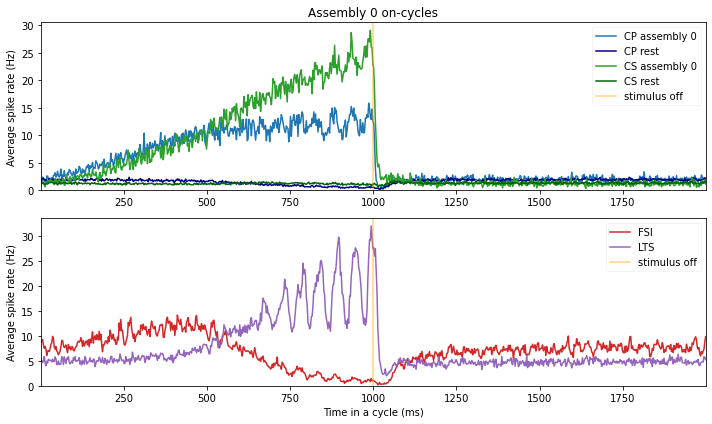

In [9]:
show_assy_idx = [0, 1]
show_assy_idx = [i for i in show_assy_idx if i in assy_idx]
has_rest = -1 in assy_idx
show_off = int(n_assy > 1)

for i in show_assy_idx:
    _, axs = plt.subplots(2 * (show_off + 1), 1,
                          figsize=(10, 6 * (show_off + 1)), squeeze=False)
    axs = axs.ravel()
    for p in pop_names:
        sel = dict(unique_cycle=i, population=p)
        color = [pop_color[p]]
        label = p
        if p in PN_pop_names:
            sel['assembly'] = [i, -1] if has_rest else [i]
            label += ' assembly %d' % i
            if has_rest:
                label = [label, p + ' rest']
                color.append(pop_color_dark[p])
            cyc_avg = grp_rspk_cyc_avg
            sub_ax = slice(0, None, 2)
        else:
            cyc_avg = pop_rspk_cyc_avg
            sub_ax = slice(1, None, 2)
        for da, ax in zip(cyc_avg, axs[sub_ax]):
            ax.set_prop_cycle('color', color)
            da = da.sel(sel)
            ax.plot(da.time, da.values.T, label=label)
    for ax in axs:
        ax.axvline(on_time * 1000, color='orange', alpha=0.5, label='stimulus off')
        ax.set_ylabel('Average spike rate (Hz)')
        ax.set_xlim(da.time[[0, -1]])
        ax.set_ylim(bottom=0.)
    for ax in axs[:2]:
        ax.legend(loc='upper right', framealpha=0.2)
    axs[0].set_title('Assembly %d on-cycles' % i)
    axs[-1].set_xlabel('Time in a cycle (ms)')
    if show_off:
        axs[2].set_title('Assembly %d off-cycles' % i)
    plt.tight_layout()
plt.show()

In [10]:
# process.combine_spike_rate(grp_rspk, 'population')
# process.combine_spike_rate(pop_rspk, 'population', index=PN_pop_names)